### 0. Load Dependencies

In [1]:
import numpy as np
import pickle
import time
from KNN_Shapley import get_VN, get_true_KNN, compute_KNN_shapley, compute_KNN_Asymmetric_Shapley, KNN_LOO, Logistic_LOO
from performance_plot import removing_sequential_data, adding_sequential_data, final_plot
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 1. Load Data

In [2]:
# Load data
n_samples = 10
m1, m2, m3, m4, m5, m6 = 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'

X_m1m2_trn_selected_lst, y_m1m2_trn_selected_lst = [], []
X_m1m2m3_trn_selected_lst, y_m1m2m3_trn_selected_lst = [], []
X_m1m2m3_val_lst, y_m1m2m3_val_lst = [], []

for i_split in range(n_samples):
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)

    X_m1m2_trn_selected_lst.append(mydict['X_m1m2_trn_selected'])
    y_m1m2_trn_selected_lst.append(mydict['y_m1m2_trn_selected'])
    X_m1m2m3_trn_selected_lst.append(mydict['X_m1m2m3_selected'])
    y_m1m2m3_trn_selected_lst.append(mydict['y_m1m2m3_selected'])

    X_m1m2m3_val_lst.append(mydict['X_{}_{}_{}_val'.format(m1, m2, m3)])
    y_m1m2m3_val_lst.append(mydict['y_{}_{}_{}_val'.format(m1, m2, m3)])

s_class_dic2 = {0: np.asarray(range(len(X_m1m2_trn_selected_lst[0]))),
                1: np.asarray(range(len(X_m1m2_trn_selected_lst[0]), len(X_m1m2m3_trn_selected_lst[0])))}

### 2. Load MC values

In [3]:
mc_sv_tree_lst, mc_asv_tree_lst, loo_tree_lst, rand_lst = [], [], [], []

seeds = [42, 123, 2020, 314, 2021, 111, 999, 777, 1010, 888]
num_permutations = 8000

for i_sample in range(n_samples):
    
    print(' ')
    print(' ')
    print('i_sample', i_sample+1)
    directory = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_sample+1)
    
    # Load tree-loo values
    with open(directory + 'loo_model=Tree_metric=accuracy.pkl', 'rb') as fp:
        loo_dict = pickle.load(fp)
    loo_tree = loo_dict['loo']
    loo_tree_lst.append(loo_tree)
    print('loo_tree.shape', loo_tree.shape)
    
    # Load tree-mc-sv
    with open(directory + 'tmc_shapley_model=Tree_metric=accuracy.pkl', 'rb') as fp:
        mc_sv_tree_dict = pickle.load(fp)
    mc_sv_tree = np.mean(mc_sv_tree_dict['marginals_tmc'][:num_permutations], axis=0)
    mc_sv_tree_lst.append(mc_sv_tree)
    print('mc_sv_tree.shape', mc_sv_tree_dict['marginals_tmc'].shape,
          mc_sv_tree_dict['marginals_tmc'][:num_permutations].shape)
    
    # Load tree-mc-asv
    with open(directory + 'tmc_asymmetric_shapley_model=Tree_metric=accuracy.pkl', 'rb') as fp:
        mc_asv_tree_dict = pickle.load(fp)
    mc_asv_tree = np.mean(mc_asv_tree_dict['marginals_tmc'][:num_permutations], axis=0)
    mc_asv_tree_lst.append(mc_asv_tree)
    print('mc_asv_tree.shape', mc_asv_tree_dict['marginals_tmc'].shape,
          mc_asv_tree_dict['marginals_tmc'][:num_permutations].shape)
    
    # random permutation of values (baseline)
    seed = seeds[i_sample-1]
    np.random.seed(seed)
    rand_lst.append(np.random.rand(len(mc_sv_tree_lst[i_sample])))

 
 
i_sample 1
loo_tree.shape (902,)
mc_sv_tree.shape (8000, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 2
loo_tree.shape (902,)
mc_sv_tree.shape (8000, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 3
loo_tree.shape (902,)
mc_sv_tree.shape (8000, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 4
loo_tree.shape (902,)
mc_sv_tree.shape (8000, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 5
loo_tree.shape (902,)
mc_sv_tree.shape (8000, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 6
loo_tree.shape (902,)
mc_sv_tree.shape (15450, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 7
loo_tree.shape (902,)
mc_sv_tree.shape (16350, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 8
loo_tree.shape (902,)
mc_sv_tree.shape (16200, 902) (8000, 902)
mc_asv_tree.shape (8000, 902) (8000, 902)
 
 
i_sample 9
loo_tree.shape (902,)


### 3. Performance Plot (Tree model, val data)

In [4]:
import matplotlib.pyplot as plt

In [7]:
def removing_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                             num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                             low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for j in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]
    
    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][i:]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_removed'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_removed'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return


def adding_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                            num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                           low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for i in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]

    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][:i]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_added'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_added'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return

i_sample 1
Removing low value sequential data experiment started...


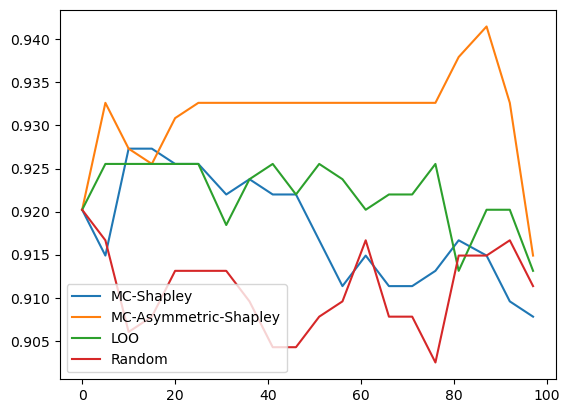

Removing high value sequential data experiment started...


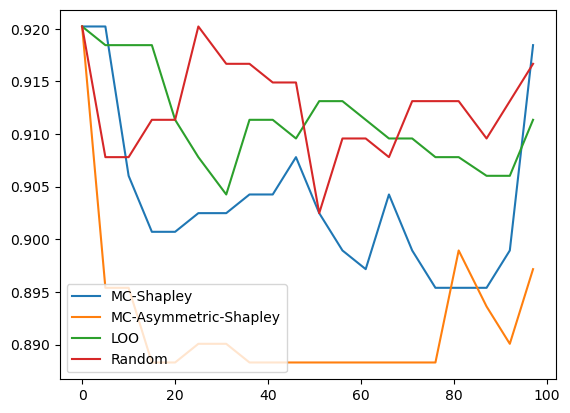

Adding low value sequential data experiment started...


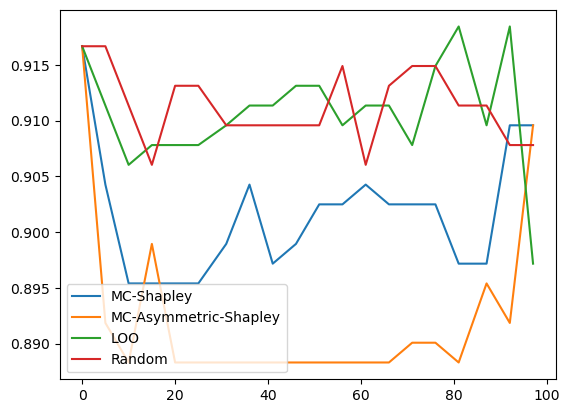

Adding high value sequential data experiment started...


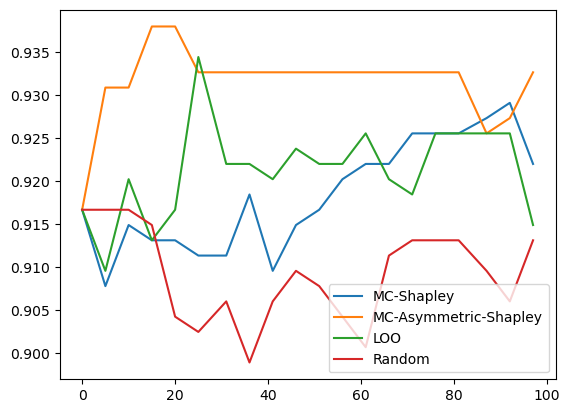

i_sample 2
Removing low value sequential data experiment started...


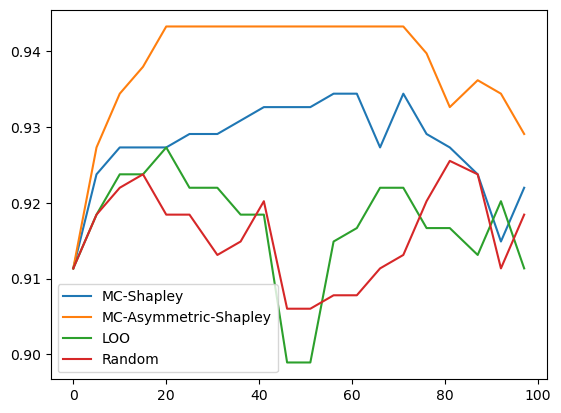

Removing high value sequential data experiment started...


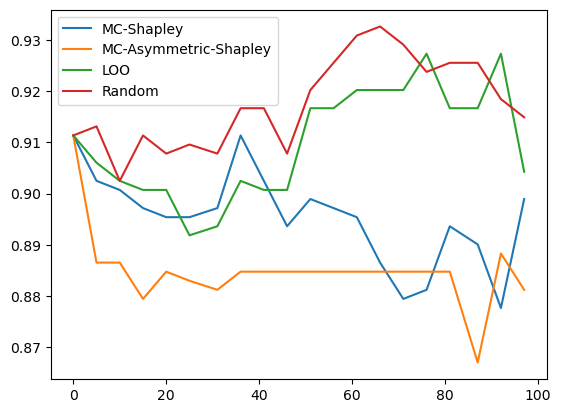

Adding low value sequential data experiment started...


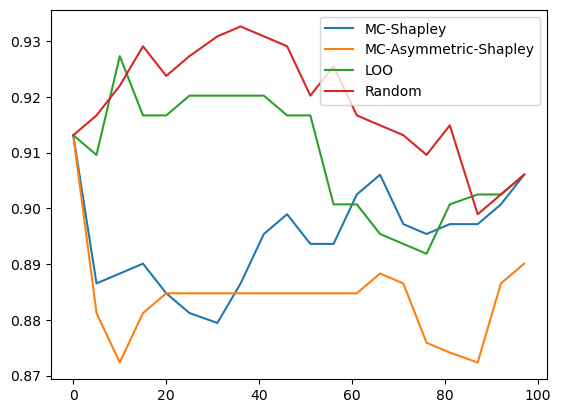

Adding high value sequential data experiment started...


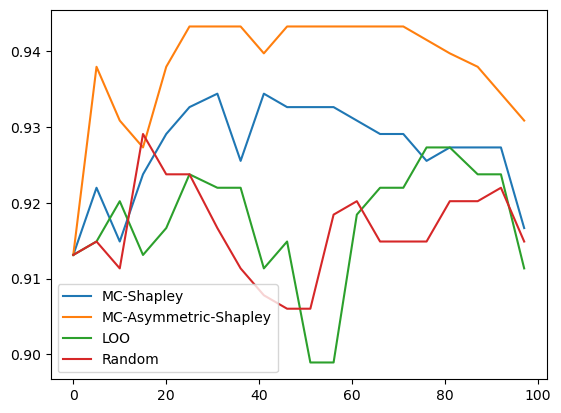

i_sample 3
Removing low value sequential data experiment started...


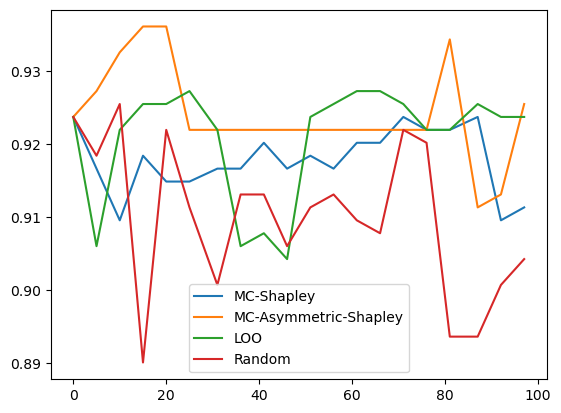

Removing high value sequential data experiment started...


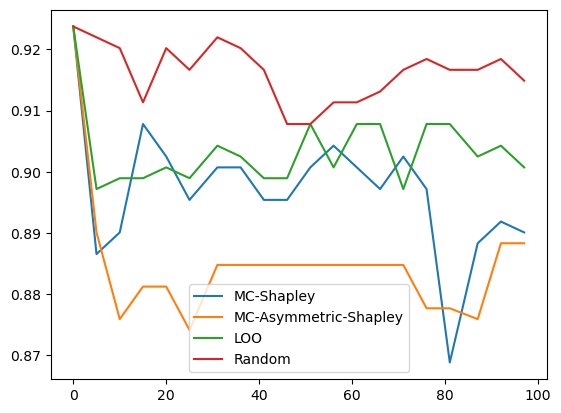

Adding low value sequential data experiment started...


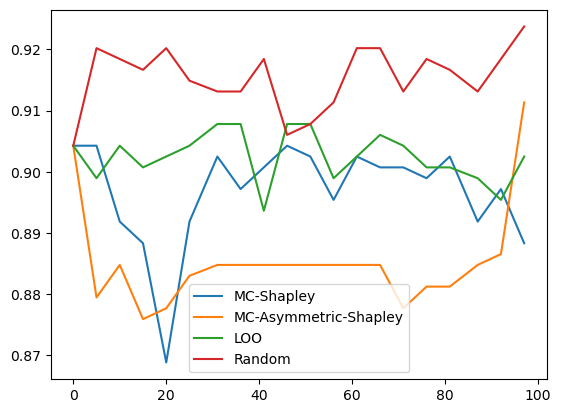

Adding high value sequential data experiment started...


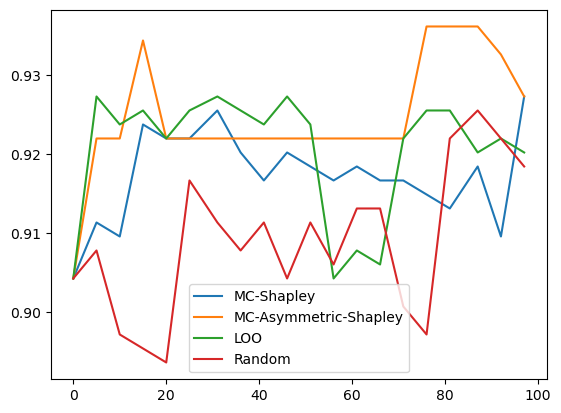

i_sample 4
Removing low value sequential data experiment started...


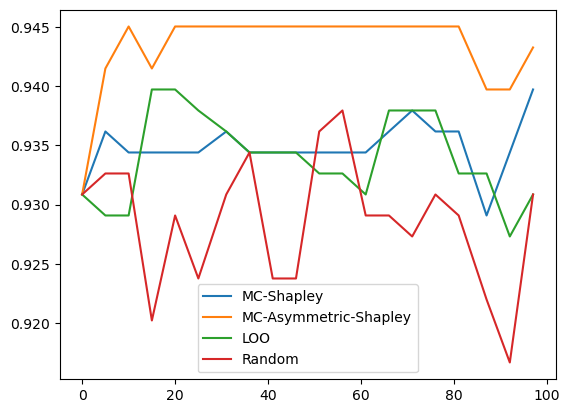

Removing high value sequential data experiment started...


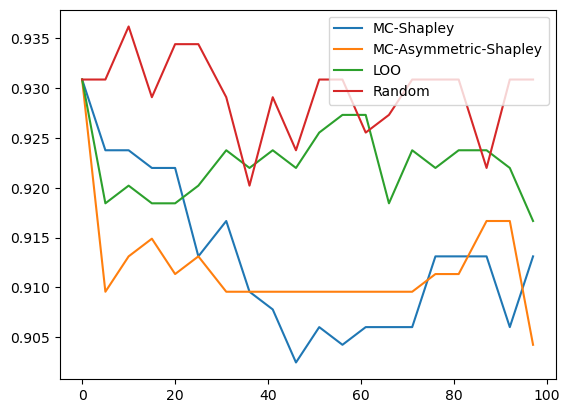

Adding low value sequential data experiment started...


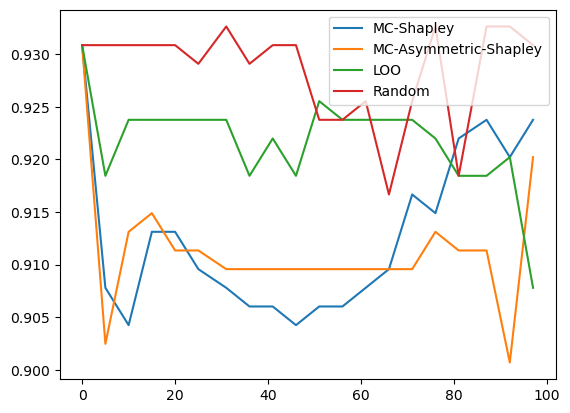

Adding high value sequential data experiment started...


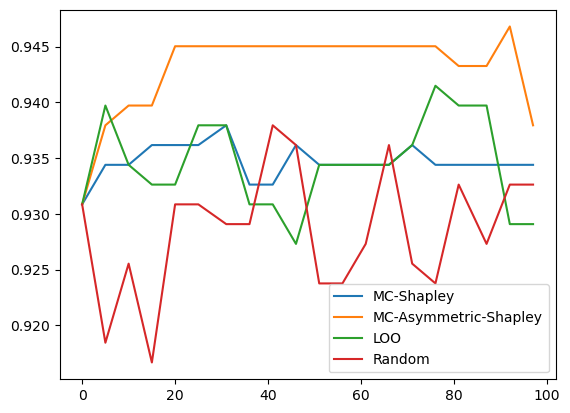

i_sample 5
Removing low value sequential data experiment started...


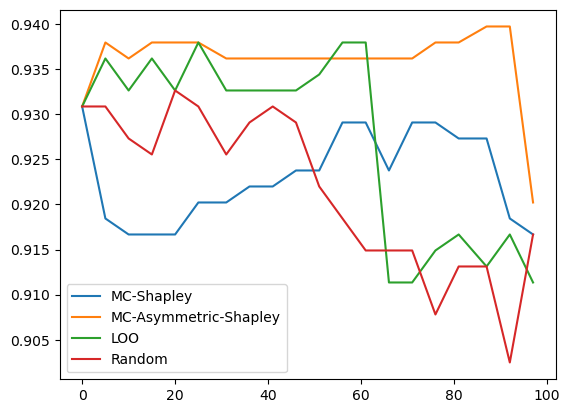

Removing high value sequential data experiment started...


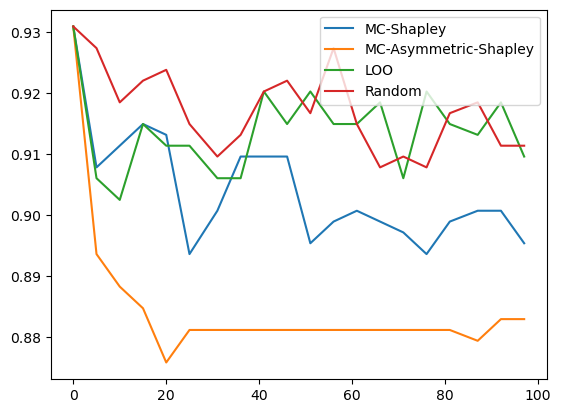

Adding low value sequential data experiment started...


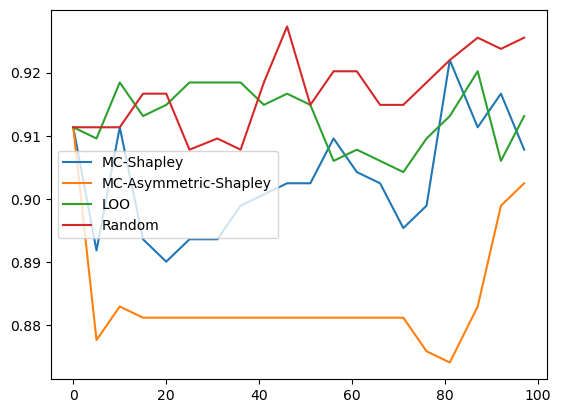

Adding high value sequential data experiment started...


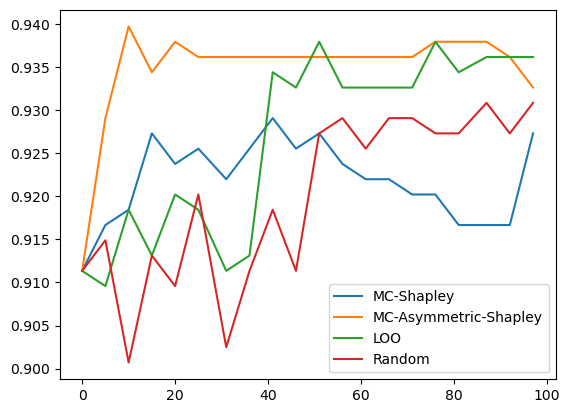

i_sample 6
Removing low value sequential data experiment started...


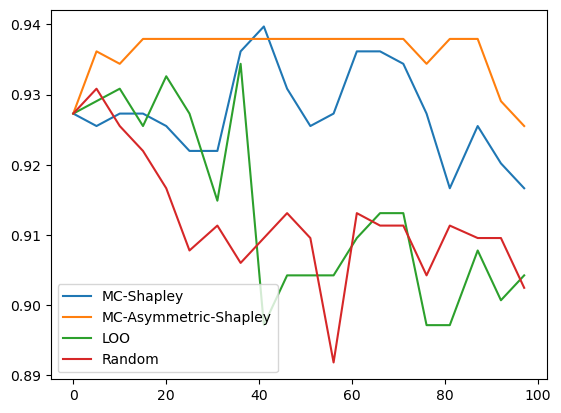

Removing high value sequential data experiment started...


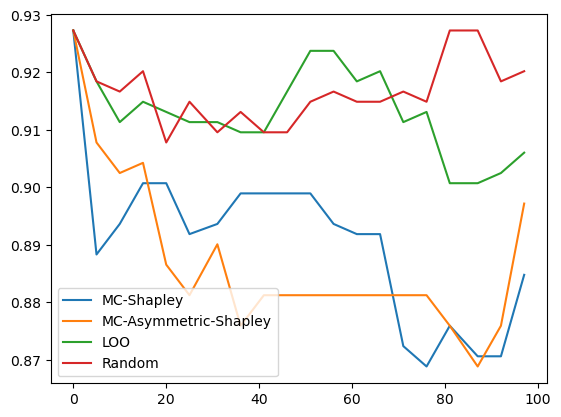

Adding low value sequential data experiment started...


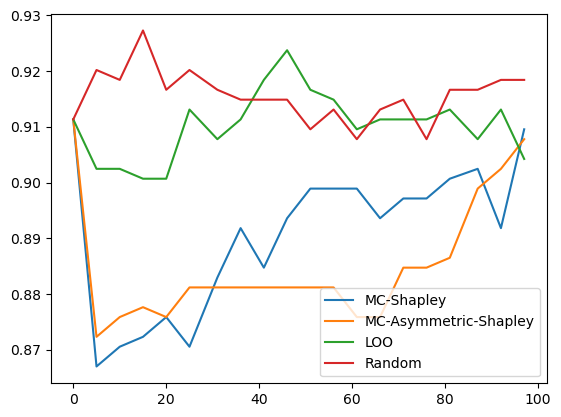

Adding high value sequential data experiment started...


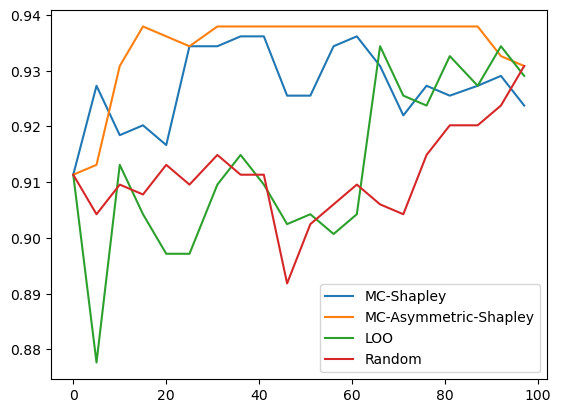

i_sample 7
Removing low value sequential data experiment started...


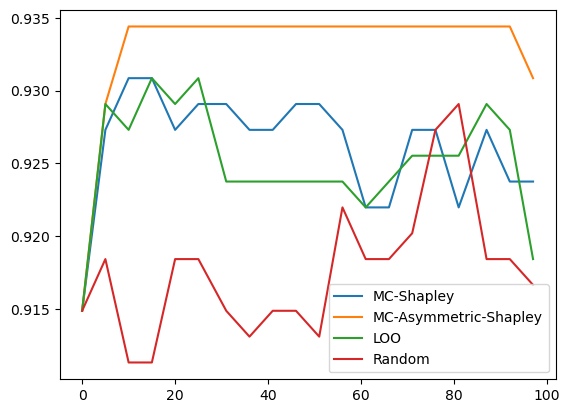

Removing high value sequential data experiment started...


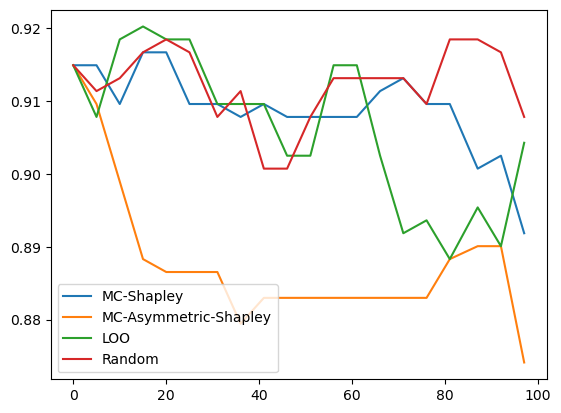

Adding low value sequential data experiment started...


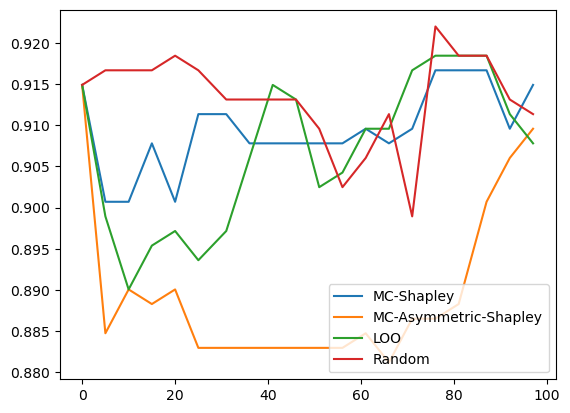

Adding high value sequential data experiment started...


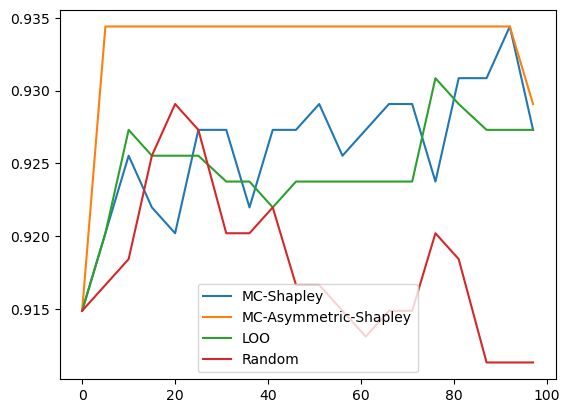

i_sample 8
Removing low value sequential data experiment started...


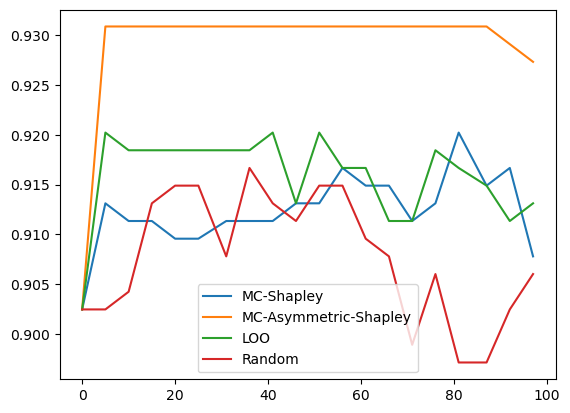

Removing high value sequential data experiment started...


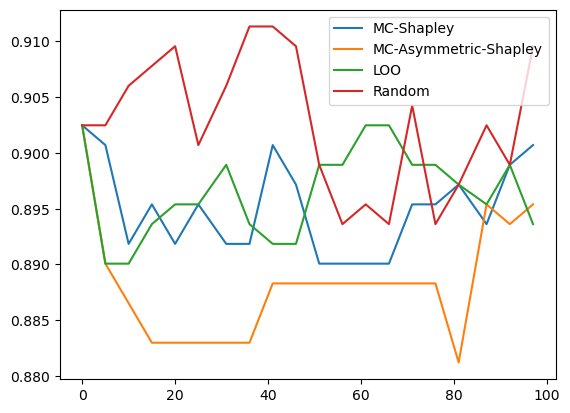

Adding low value sequential data experiment started...


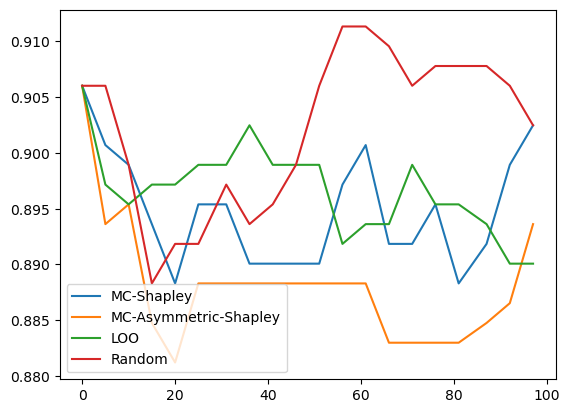

Adding high value sequential data experiment started...


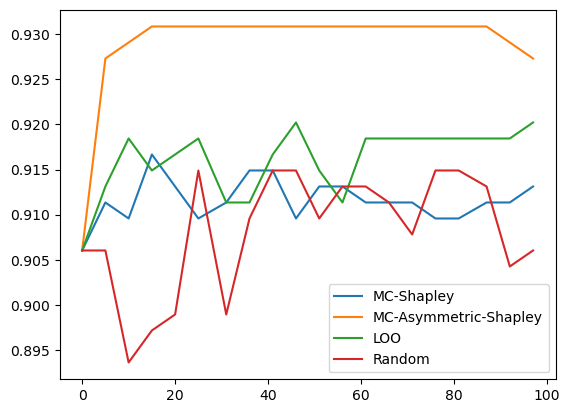

i_sample 9
Removing low value sequential data experiment started...


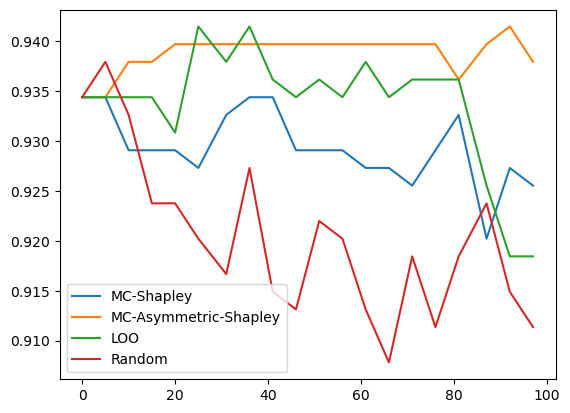

Removing high value sequential data experiment started...


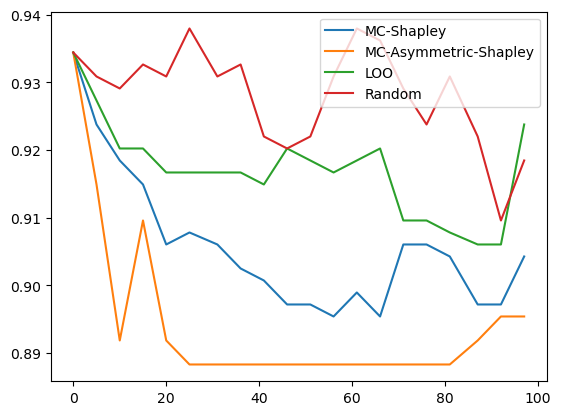

Adding low value sequential data experiment started...


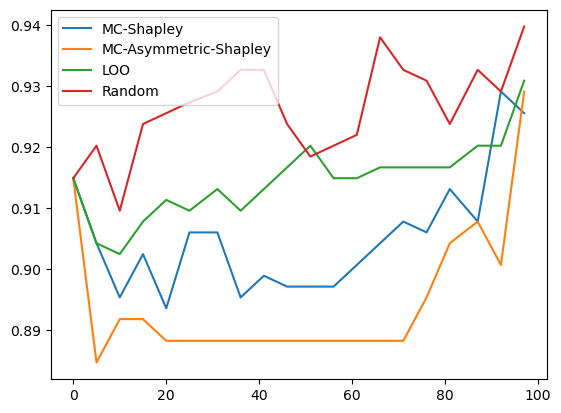

Adding high value sequential data experiment started...


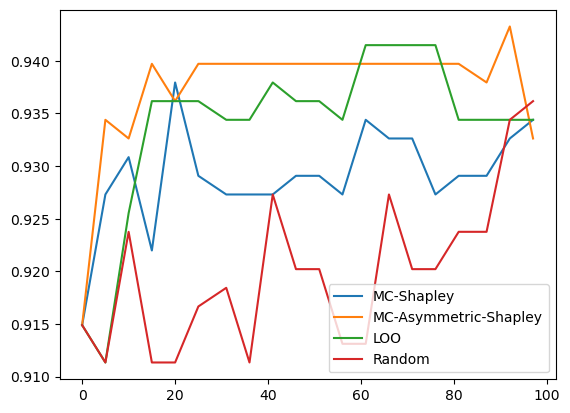

i_sample 10
Removing low value sequential data experiment started...


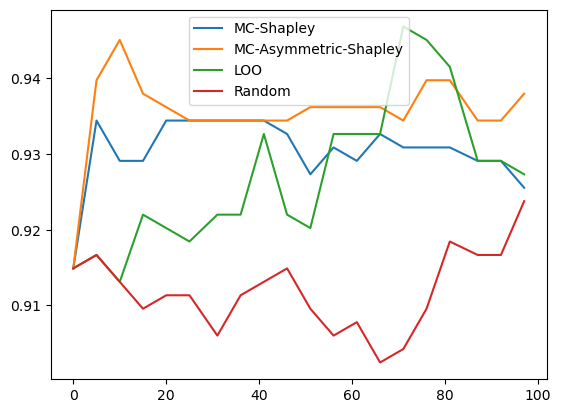

Removing high value sequential data experiment started...


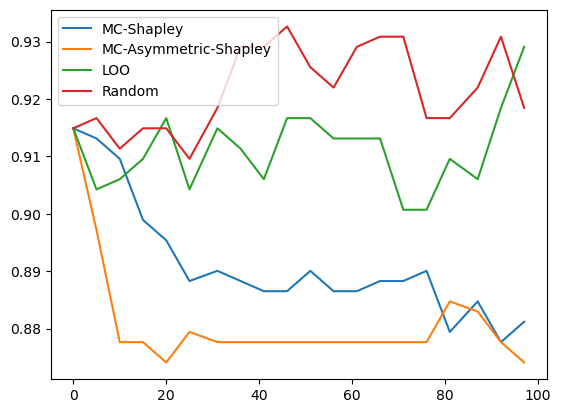

Adding low value sequential data experiment started...


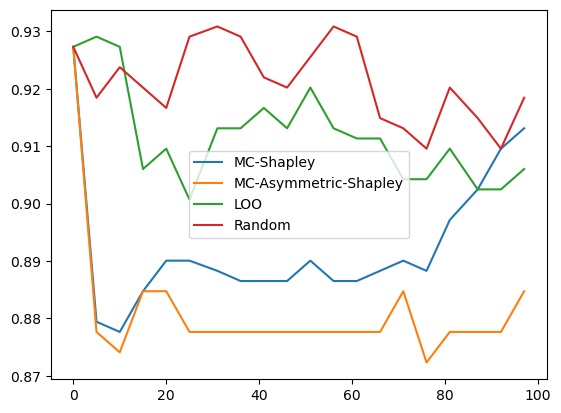

Adding high value sequential data experiment started...


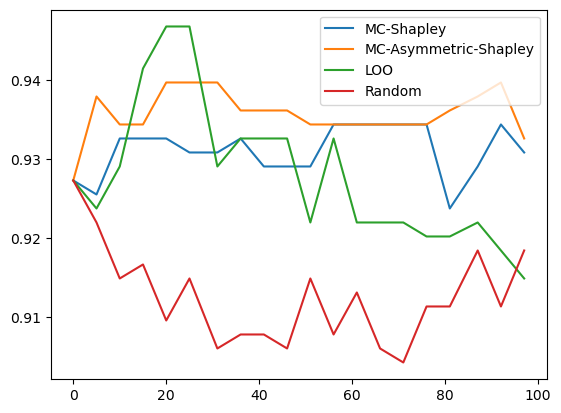

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=666)

for i_sample in range(n_samples):
    
    print('i_sample', i_sample+1)
    directory = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_sample+1)
    
    shap_vals_lst = [mc_sv_tree_lst[i_sample], mc_asv_tree_lst[i_sample], 
                     loo_tree_lst[i_sample], rand_lst[i_sample]]
    
    shap_vals_algo_lst = ['MC-Shapley', 'MC-Asymmetric-Shapley', 'LOO', 'Random']
    
    X_m1m2_trn_selected = X_m1m2_trn_selected_lst[i_sample]
    y_m1m2_trn_selected = y_m1m2_trn_selected_lst[i_sample]
    X_m1m2m3_trn_selected = X_m1m2m3_trn_selected_lst[i_sample]
    y_m1m2m3_trn_selected = y_m1m2m3_trn_selected_lst[i_sample]
    
    X_m1m2m3_val = X_m1m2m3_val_lst[i_sample]
    y_m1m2m3_val = y_m1m2m3_val_lst[i_sample]
    
    num_trn_class0 = len(X_m1m2_trn_selected)
    ind_arr = np.zeros(len(X_m1m2m3_trn_selected))
    ind_arr[:len(X_m1m2_trn_selected)] = 1
    
    remove_low_directory = directory + 'remove_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory = directory + 'remove_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory = directory + 'add_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory = directory + 'add_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'

    print('Removing low value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected, 
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val, plot_every_percentage = 0.05,
                             num_trn_ori=num_trn_class0, ind_arr=ind_arr, directory=remove_low_directory,
                             model=model, metrics='acc', low_value_first=True)

    print('Removing high value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected, 
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val, plot_every_percentage = 0.05,
                             num_trn_ori=num_trn_class0, ind_arr=ind_arr, directory=remove_high_directory,
                             model=model, metrics='acc', low_value_first=False)

    print('Adding low value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected, 
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val, plot_every_percentage = 0.05,
                           num_trn_ori=num_trn_class0, ind_arr=ind_arr, directory=add_low_directory,
                           model=model, metrics='acc', low_value_first=True)

    print('Adding high value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected, 
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val, plot_every_percentage = 0.05,
                           num_trn_ori=num_trn_class0, ind_arr=ind_arr, directory=add_high_directory,
                           model=model, metrics='acc', low_value_first=False)

### 4. Final Plot (Tree model)

In [9]:
shap_vals_algo_lst = ['MC-Shapley', 'MC-Asymmetric-Shapley', 'LOO', 'Random']
remove_low_avg, remove_high_avg, add_low_avg, add_high_avg = {}, {}, {}, {}

for i_sample in range(n_samples):
    
    print('i_sample', i_sample+1)
    directory = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_sample+1)
    
    remove_low_directory = directory + 'remove_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory = directory + 'remove_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory = directory + 'add_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory = directory + 'add_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'

    with open(remove_low_directory, 'rb') as fp:
        remove_low = pickle.load(fp)
    
    with open(remove_high_directory, 'rb') as fp:
        remove_high = pickle.load(fp)

    with open(add_low_directory, 'rb') as fp:
        add_low = pickle.load(fp)

    with open(add_high_directory, 'rb') as fp:
        add_high = pickle.load(fp)
    
    if i_sample == 0:
        for key in remove_low.keys():
            remove_low_avg[key] = [np.asarray(remove_low[key])]
            remove_high_avg[key] = [np.asarray(remove_high[key])]
    else:
        for key in remove_low.keys():
            remove_low_avg[key].append(np.asarray(remove_low[key]))
            remove_high_avg[key].append(np.asarray(remove_high[key]))
    
    if i_sample == 0:
        for key in add_low.keys():
            add_low_avg[key] = [np.asarray(add_low[key])]
            add_high_avg[key] = [np.asarray(add_high[key])]
    else:
        for key in add_low.keys():
            add_low_avg[key].append(np.asarray(add_low[key]))
            add_high_avg[key].append(np.asarray(add_high[key]))

            
for key in remove_high_avg.keys():
    if key == 'frac_data_removed':
        remove_high_avg[key] = remove_high_avg[key][0]
        remove_low_avg[key] = remove_low_avg[key][0]
    else:
        remove_high_avg[key] = np.vstack(remove_high_avg[key])
        remove_low_avg[key] = np.vstack(remove_low_avg[key])


for key in add_high_avg.keys():
    if key == 'frac_data_added':
        add_high_avg[key] = add_high_avg[key][0]
        add_low_avg[key] = add_low_avg[key][0]
    else:
        add_high_avg[key] = np.vstack(add_high_avg[key])
        add_low_avg[key] = np.vstack(add_low_avg[key])

i_sample 1
i_sample 2
i_sample 3
i_sample 4
i_sample 5
i_sample 6
i_sample 7
i_sample 8
i_sample 9
i_sample 10


In [10]:
def final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, add_low_avg, shap_algo_lst, dataset,
                   remove_add_ratio, xticks, root_dir, modelname, imbalance=False, experiment='ex1'):
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    dataset_font, title_font, label_font, ticks_font, legend_font = 15, 10, 8, 8, 6
    
    # Define the color map for the methods
    color_map = {
        'KNN-Shapley': 'purple',
        'KNN-Asymmetric-Shapley': 'orange',
        'MC-Shapley': 'blue',
        'MC-Asymmetric-Shapley': 'red',
        'LOO': 'green',
        'Random': 'grey'
    }

    # Define the line style for the methods
    line_style_map = {
        'KNN-Shapley': 'solid',
        'KNN-Asymmetric-Shapley':'solid',
        'MC-Shapley': 'solid',
        'MC-Asymmetric-Shapley': 'solid',
        'LOO':'solid',
        'Random': 'solid'
    }

    # Define the marker shapes for the methods
    marker_map = {
        'KNN-Shapley': '*',
        'KNN-Asymmetric-Shapley':'+',
        'MC-Shapley': 'o',  # Circle marker
        'MC-Asymmetric-Shapley': 's',  # Square marker
        'LOO': '^',  # Triangle marker
        'Random': 'd'  # Diamond marker
    }

    data_lst = [remove_low_avg, remove_high_avg, add_low_avg, add_high_avg]
    keys = ['frac_data_removed', 'frac_data_removed', 'frac_data_added', 'frac_data_added']

    # Define subtitles and x_labels
    if experiment == 'ex1':
        subtitles = ['Removing low value\nAugust data', 'Removing high value\nAugust data',
                     'Adding low value\nAugust data', 'Adding high value\nAugust data']
        x_labels = ['Fraction of August data removed (%)', 'Fraction of August data removed (%)',
                    'Fraction of August data added (%)', 'Fraction of August data added (%)']
    else:
        subtitles = ['Removing low value\nSeptember data', 'Removing high value\nSeptember data',
                     'Adding low value\nSeptember data', 'Adding high value\nSeptember data']
        x_labels = ['Fraction of September data removed (%)', 'Fraction of September data removed (%)',
                    'Fraction of September data added (%)', 'Fraction of September data added (%)']

    for i in range(len(data_lst)):
        ymin, ymax = 1, 0
        for j in range(len(shap_algo_lst)):
            bool_ratio = (np.array(data_lst[i][keys[i]]) <= remove_add_ratio)
            
            results = data_lst[i][shap_algo_lst[j]]
            normalized_results = data_lst[i][shap_algo_lst[j]] / data_lst[i][shap_algo_lst[j]][:, [0]]
            # Calculate the mean across the n repetitions
            mean_rslts = np.mean(normalized_results, axis=0)     
            # Calculate the 90% confidence interval
            confidence_band = 1.645 * np.std(normalized_results, axis=0) / np.sqrt(normalized_results.shape[0])
            
            # Plotting the mean and confidence band with markers
            axes[i].plot(
                data_lst[i][keys[i]][bool_ratio], 
                mean_rslts[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                linestyle=line_style_map[shap_algo_lst[j]], 
                marker=marker_map[shap_algo_lst[j]],  # Apply marker for each algorithm
                lw=2, markersize=4
            )
            axes[i].fill_between(
                data_lst[i][keys[i]][bool_ratio],
                mean_rslts[bool_ratio] - confidence_band[bool_ratio], 
                mean_rslts[bool_ratio] + confidence_band[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                alpha=0.1, 
                label="90% Confidence Band"
            )
            if min(mean_rslts[bool_ratio] - confidence_band[bool_ratio]) < ymin:
                ymin = min(mean_rslts[bool_ratio] - confidence_band[bool_ratio])
            if max(mean_rslts[bool_ratio] + confidence_band[bool_ratio]) > ymax:
                ymax = max(mean_rslts[bool_ratio] + confidence_band[bool_ratio])
            
        # Set x-ticks
        axes[i].set_xticks(xticks)
        
        # Set y-lim
        if i == 0:
            axes[i].set_ylim((ymin-0.03, ymax+0.01))
        else:
            axes[i].set_ylim((ymin-0.01, ymax+0.01))
            
        # Set titles with bold font and in two lines
        axes[i].set_title(subtitles[i], fontsize=title_font, fontweight='bold')
        axes[i].set_xlabel(x_labels[i], fontsize=label_font)

        # Set the y-label and add the dataset name to the first plot
        if imbalance:
            axes[i].set_ylabel('Relative AUC (%)', fontsize=label_font)
        else:
            axes[i].set_ylabel('Relative accuracy (%)', fontsize=label_font)

        # Add the dataset name to the left side of the first plot
        if i == 0:
            axes[i].text(-0.5, 0.8, dataset, fontsize=dataset_font,
                         fontweight='bold', 
                         va='top', ha='center', rotation=90,
                         transform=axes[i].transAxes)

    # Adjust the spacing between plots to make more room for y-labels
    plt.subplots_adjust(left=0.1, right=0.85, wspace=0.5)  # Increase wspace for more room between plots

    # Create custom colorbar based on the defined color map
    from matplotlib.colors import ListedColormap
    import matplotlib as mpl

    # Convert the color map values into a colormap object
    cmap = ListedColormap([color_map[algo] for algo in shap_algo_lst])

    # Normalize the ticks for the colorbar
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(len(shap_algo_lst)+1)-0.5, ncolors=len(shap_algo_lst))

    # Create the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colorbar = plt.colorbar(sm, ax=axes, orientation='vertical', pad=0.02, fraction=0.05)
    colorbar.set_ticks(np.arange(len(shap_algo_lst)))
    colorbar.set_ticklabels(shap_algo_lst)
    
    # Save the figure with bbox_inches to avoid cutting off the titles
    plt.savefig(root_dir + 'final_plot_model={}.jpg'.format(modelname), dpi=500, 
                bbox_inches='tight')
    plt.show()
    return

In [11]:
remove_high_avg['frac_data_removed']

array([ 0.,  5., 10., 15., 20., 25., 31., 36., 41., 46., 51., 56., 61.,
       66., 71., 76., 81., 87., 92., 97.])

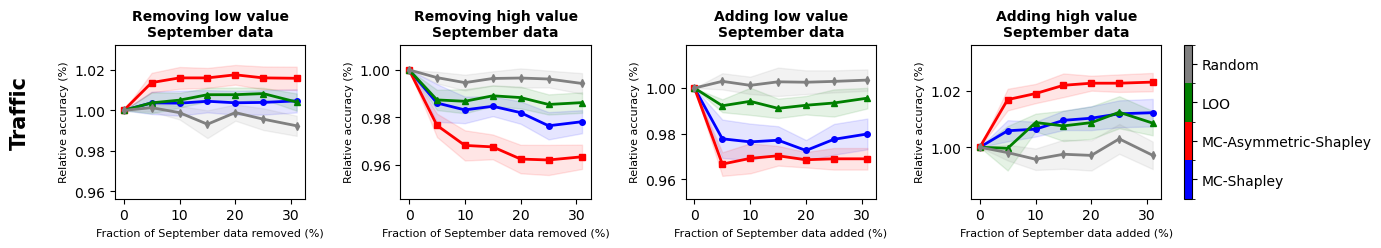

In [12]:
# Plot final plot
import matplotlib.pyplot as plt

final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, 
               add_low_avg, shap_vals_algo_lst, remove_add_ratio = 35,
               xticks=[0, 10, 20, 30], modelname='tree',
               root_dir='experiments/sequential data valuation/traffic 10 random splits/experiment_2/validation data/',
               dataset='Traffic', experiment='ex2', imbalance=False)